# Predicting Evergreeness of Content with Decision Trees and Random Forests

In [2]:
## DATA DICTIONARY

In [3]:
from __future__ import print_function
%matplotlib inline
import pandas as pd
import json
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("../../assets/dataset/stumbleupon.tsv", sep='\t')
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))
data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...


## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

> #### A sample of URLs is below, where label = 1 are 'evergreen' websites

In [4]:
data[['url', 'label']].head()

,url,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,0
1,http://www.popsci.com/technology/article/2012-...,1
2,http://www.menshealth.com/health/flu-fighting-...,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,1
4,http://bleacherreport.com/articles/1205138-the...,0


### Exercises to Get Started

 ### Exercise: 1. In a group: Brainstorm 3 - 5 features you could develop that would be useful for predicting evergreen websites.
 ###  Exercise: 2. After looking at the dataset, can you model or quantify any of the characteristics you wanted?
- I.E. If you believe high-image content websites are likely to be evergreen, how can you build a feature that represents that?
- I.E. If you believe weather content is likely NOT to be evergreen, how might you build a feature that represents that?

### Split up and develop 1-3 of the those features independently.

### Exercise: 3. Does being a news site affect evergreeness? 
Compute or plot the percentage of news related evergreen sites.

In [5]:
import seaborn as sb
%matplotlib inline

# Option 1: Find out P ( evergreen | is_news = 1) vs P ( evergreen | is_news = ?)

data.groupby(['is_news'])[['label']].mean()

##  OR

# import seaborn as sb
# %matplotlib inline

# sb.factorplot(x='is_news', 
#               y='label',
#               kind='bar',
#               data = data)


,label
is_news,
1,0.516916
?,0.507562


### Exercise: 4. Does category in general affect evergreeness? 
Plot the rate of evergreen sites for all Alchemy categories.

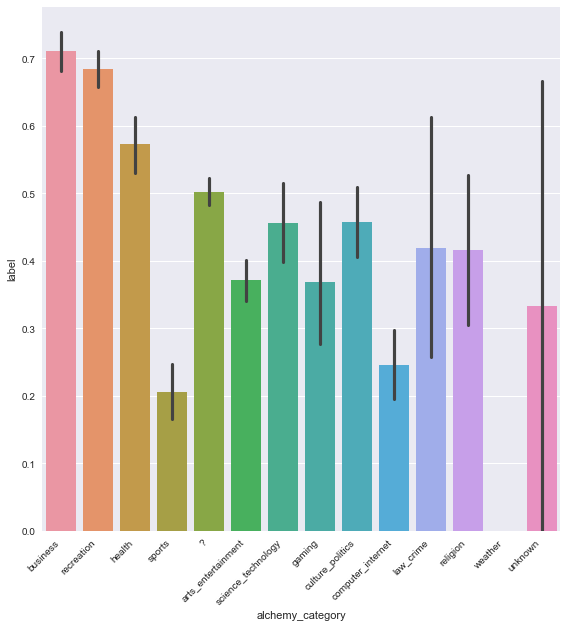

In [6]:
data.groupby(['alchemy_category'])[['label']].mean()


##  OR

import seaborn as sb
%matplotlib inline

p = sb.factorplot(x='alchemy_category', 
              y='label',
              kind='bar',
              data = data,
              size = 8
            )
p.set_xticklabels(rotation=45, horizontalalignment='right')

### Exercise: 5. How many articles are there per category?

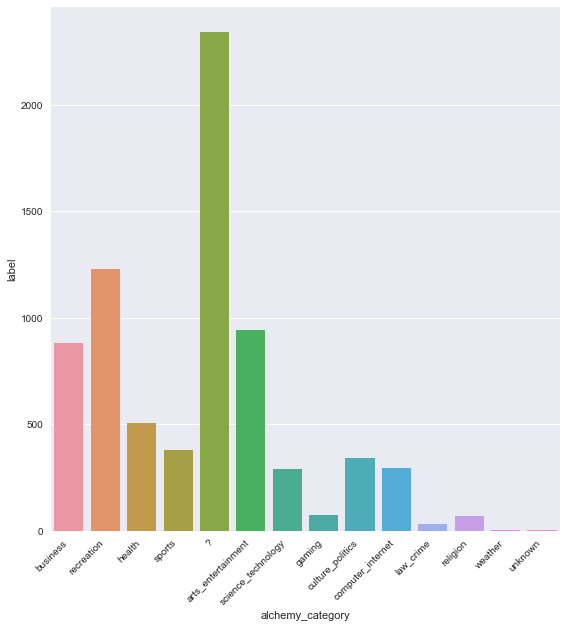

In [7]:
data.groupby(['alchemy_category'])[['label']].count()


##  OR

import seaborn as sb
%matplotlib inline

p = sb.factorplot(x='alchemy_category', 
              y='label',
              kind='bar',
              data = data,
              size = 8,
              estimator=len
            )
p.set_xticklabels(rotation=45, horizontalalignment='right')

> #### Let's try extracting some of the text content.
> ### Exercise: 6. Create a feature for the title containing 'recipe'. 
Is the % of evegreen websites higher or lower on pages that have recipe in the the title?

In [8]:
# Option 1: Create a function to check for this

def has_recipe(text_in):
    try:
        if 'recipe' in str(text_in).lower():
            return 1
        else:
            return 0
    except: 
        return 0
        
data['recipe'] = data['title'].map(has_recipe)

# Option 2: lambda functions

#data['recipe'] = data['title'].map(lambda t: 1 if 'recipe' in str(t).lower() else 0)


# Option 3: string functions
data['recipe'] = data['title'].str.contains('recipe')

###  Let's Explore Some Decision Trees

 ### Demo: Build a decision tree model to predict the "evergreeness" of a given website. 

In [18]:
from sklearn.tree import DecisionTreeClassifier

# model = DecisionTreeClassifier(criterion='entropy')

model = DecisionTreeClassifier(criterion='entropy')

X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)
    
    
# Fits the model
model.fit(X, y)

# Helper function to visualize Decision Trees (creates a file tree.png)

from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(model, n):
    dotfile = open(n, 'w')
    export_graphviz(model,
                              out_file = dotfile,
                              feature_names = X.columns)
    dotfile.close()
    system("dot -Tpng tree.dot -o tree.png")
    system("dot -Tpng tree.dot -o tree.jpg")
    system("dot -Tpng tree_e.dot -o tree_e.png")
    
build_tree_image(model,"tree_e.dot")

![decision tree evergreen data](tree.png)

![decision tree evergreen ent](tree_e.png)

## Decision Trees in scikit-learn

 ### Exercise: Evaluate the decision tree using cross-validation; use AUC as the evaluation metric.

In [10]:
from sklearn.cross_validation import cross_val_score

# ... #

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.50316554  0.52946319  0.55442228  0.53529299  0.5553024 ], Average AUC 0.535529281499


###  Adjusting Decision Trees to Avoid Overfitting

 ### Demo: Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

In [11]:
model = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)

model.fit(X, y)
build_tree_image(model)

 ### Demo: Build a random forest model to predict the evergreeness of a website. 

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)
    
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Demo: Extracting importance of features

In [13]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
1,html_ratio,0.527978
0,image_ratio,0.441959
2,recipe,0.030063


 ### Exercise: Evaluate the Random Forest model using cross-validation; increase the number of estimators and view how that improves predictive performance.

In [14]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

for n_trees in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X, y, scoring='roc_auc')
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees, scores, scores.mean()))

CV AUC [ 0.56104352  0.58246619  0.57889015], Average AUC 0.574133287794
n trees: 1, CV AUC [ 0.53221218  0.52761981  0.52942134], Average AUC 0.529751109742
n trees: 11, CV AUC [ 0.56509465  0.58486373  0.57511653], Average AUC 0.575024968993
n trees: 21, CV AUC [ 0.5609306   0.59448893  0.57247831], Average AUC 0.575965943396
n trees: 31, CV AUC [ 0.56619517  0.58538388  0.5842526 ], Average AUC 0.578610551443
n trees: 41, CV AUC [ 0.56804392  0.58413604  0.58135938], Average AUC 0.577846444447
n trees: 51, CV AUC [ 0.56532611  0.58812016  0.57999776], Average AUC 0.577814676706
n trees: 61, CV AUC [ 0.5655896   0.58885115  0.58568928], Average AUC 0.58004334518
n trees: 71, CV AUC [ 0.56497644  0.58812115  0.58213692], Average AUC 0.578411501608
n trees: 81, CV AUC [ 0.56961926  0.58588487  0.58264922], Average AUC 0.579384451893
n trees: 91, CV AUC [ 0.56999601  0.59006397  0.58681608], Average AUC 0.582292017818


##  Independent Practice: Evaluate Random Forest Using Cross-Validation

1. Continue adding input variables to the model that you think may be relevant
2. For each feature:
  - Evaluate the model for improved predictive performance using cross-validation
  - Evaluate the _importance_ of the feature
  - 
3. **Bonus**: Just like the 'recipe' feature, add in similar text features and evaluate their performance.


In [15]:
## 1. Building a model with more relevant features

model = RandomForestClassifier(n_estimators=50)

# Continue to add features to X
#     Build dummy features, include quantitative features, or add text features
X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()

y = X['label']

X.drop('label', axis=1, inplace=True)


## 2a. Evaluate predictive performance for the given feature set
scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

# 3 (BONUS): Adding in text features

# Check for keywords in the title
data['PhotoInTitle'] = data['title'].fillna('').str.lower().str.contains('photo').astype(int)
X = data[['image_ratio', 'html_ratio', 'recipe', 'PhotoInTitle', 'label']].dropna()
X.drop('label', axis=1, inplace=True)


scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))


## 2b. Evaluating feature importances

# Fit a model on the whole dataset
model.fit(X, y)

# Get columns and their scores
features = X.columns
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

CV AUC [ 0.56788708  0.58399658  0.58109049], Average AUC 0.57765805073
CV AUC [ 0.56171348  0.59592415  0.58830204], Average AUC 0.581979890766


,Features,Importance Score
1,html_ratio,0.524348
0,image_ratio,0.439317
2,recipe,0.030648
3,PhotoInTitle,0.005687
